In [ ]:
!apt install ffmpeg
!pip install spleeter
!pip install audio-separator
!pip install museval

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
  Using cached protobuf-3.19.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.24.4
    Uninstalling protobuf-4.24.4:
      Successfully uninstalled protobuf-4.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
onnx 1.15.0 requires protobuf>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
tensorflow-datasets 4.9.3 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.


  Using cached protobuf-4.24.4-cp37-abi3-manylinux2014_x86_64.whl (311 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.24.4 which is incompatible.
tensorflow 2.9.3 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.24.4 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.24.4 which is incompatible.


# Automashup : Automatic mashup generator.

Automatic mashup generator algorithm. A Mashup is defined as a mix of different songs, usually formed by mixing the instrumental line of one song with the vocal line of another. In the present project we seek to implement a source separation algorithm, followed by the creation of a new song, mixing the instrumental and vocal lines of the supplied songs.




In [ ]:
import matplotlib.pyplot as plt
import librosa.display

import numpy as np
import pandas as pd
import librosa

from IPython.display import Audio

In [ ]:
#Load audio, the audio is sampled at 44100 Hz
audio, sr = librosa.load('morat.mp3', sr=44100)
Audio(data=audio, rate=sr)

/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [ ]:
print(f"Sampling rate: {sr}")
print(f"Audio array length (duration*sr): {audio.shape[0]}")

Sampling rate: 44100
Audio array length (duration*sr): 502895


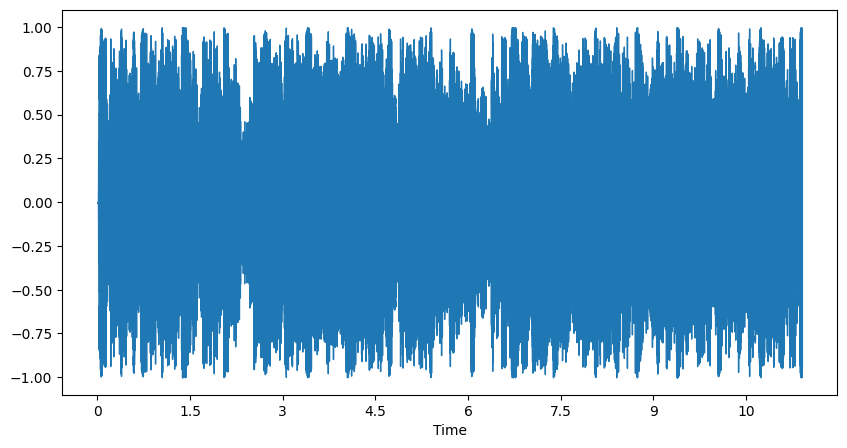

In [ ]:
#Visualize audio
plt.figure(figsize=(10, 5))
librosa.display.waveshow(audio, sr=sr)
plt.show()

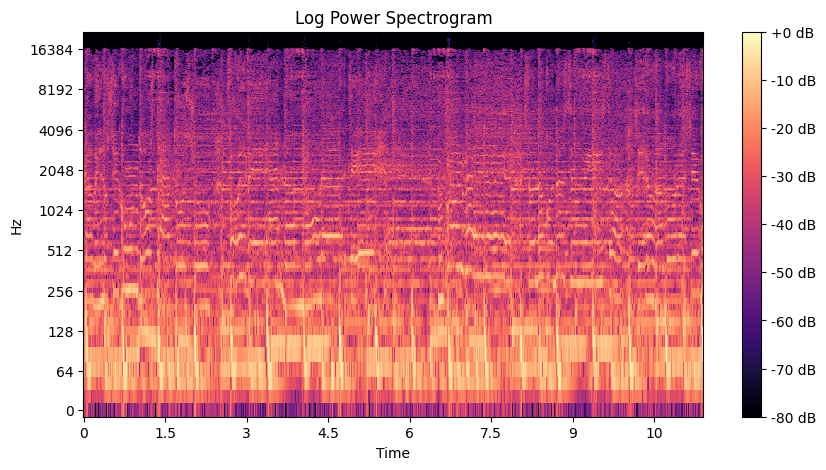

In [ ]:
#Get and visualize time-frequency domain
fig, ax = plt.subplots(figsize=(10, 5))
S = np.abs(librosa.stft(audio))**2
img = librosa.display.specshow(librosa.power_to_db(S,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax)
ax.set_title('Log Power Spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

We can see that the audio frequencies > 11 kHz, so, we can not apply spleeter models (**Unet, Bi-LSTM**) which are trained for performing separation up to 11kHz.

Spleeter released new model's version to separate audios up to 16kHz, use the same pretrain model but spectrogram estimation at separation time is then done until 16kHz. This may lead to unexpected artefacts, still we employ this model to test the performance instead of the previous one.

## Source separation algorithms


### Spleeter method


In [ ]:
#Run source separation (mixture -> 4 stems: vocals, drums, bass, other)
!spleeter separate -o source_separation -p spleeter:4stems-16kHz morat.mp3

Traceback (most recent call last):
  File "/usr/local/bin/spleeter", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/spleeter/__main__.py", line 267, in entrypoint
    spleeter()
  File "/usr/local/lib/python3.10/dist-packages/typer/main.py", line 214, in __call__
    return get_command(self)(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 829, in __call__
    return self.main(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 782, in main
    rv = self.invoke(ctx)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1259, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1066, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 610, in invoke
    return callback(*args, **kwargs)
  File "

In [ ]:
#Play estimated vocals
Audio('source_separation/morat/vocals.wav')

ValueError: ignored

In [ ]:
#Play estimated drums
Audio('source_separation/morat/drums.wav')

In [ ]:
#Play estimated bass
Audio('source_separation/morat/bass.wav')

In [ ]:
#Play estimated other stem
Audio('source_separation/morat/other.wav')

In [ ]:
#Load and visualize ground truth and estimated stems (Waveform)
bass, _ = librosa.load('bass.mp3', sr=44100)
drums, _ = librosa.load('drums.mp3', sr=44100)
vocals, _ = librosa.load('vocals.mp3', sr=44100)
other, _ = librosa.load('other.mp3', sr=44100)

bass_est, _ = librosa.load('source_separation/morat/bass.wav', sr=44100)
drums_est, _ = librosa.load('source_separation/morat/drums.wav', sr=44100)
vocals_est, _ = librosa.load('source_separation/morat/vocals.wav', sr=44100)
other_est, _ = librosa.load('source_separation/morat/other.wav', sr=44100)

fig, ax = plt.subplots(nrows=3, figsize=(12,10), sharex=True)
librosa.display.waveshow(audio, sr=sr, ax=ax[0])
ax[0].set(title='Mixture')
ax[0].label_outer()

librosa.display.waveshow(bass, sr=sr, color='r', alpha=0.6, ax=ax[1], label='bass')
librosa.display.waveshow(other, sr=sr, color='g', alpha=0.6, ax=ax[1], label='other')
librosa.display.waveshow(vocals, sr=sr, color='b', alpha=0.6, ax=ax[1], label='vocals')
librosa.display.waveshow(drums, sr=sr, color='orange', alpha=0.6, ax=ax[1], label='drums')
ax[1].set(title='Ground truth stems')
ax[1].legend()
ax[1].label_outer()

librosa.display.waveshow(bass_est, sr=sr, color='r', alpha=0.6, ax=ax[2], label='bass_est')
librosa.display.waveshow(other_est, sr=sr, color='g', alpha=0.6, ax=ax[2], label='other_est')
librosa.display.waveshow(vocals_est, sr=sr, color='b', alpha=0.6, ax=ax[2], label='vocals_est')
librosa.display.waveshow(drums_est, sr=sr, color='orange', alpha=0.6, ax=ax[2], label='drums_est')
ax[2].set(title='Estimated stems')
ax[2].legend()
plt.show()

In [ ]:
#Visualize ground truth and estimated stems (TF domain)
S_bass = np.abs(librosa.stft(bass))**2
S_drums = np.abs(librosa.stft(drums))**2
S_vocals = np.abs(librosa.stft(vocals))**2
S_other = np.abs(librosa.stft(other))**2

S_bass_est = np.abs(librosa.stft(bass_est))**2
S_drums_est = np.abs(librosa.stft(drums_est))**2
S_vocals_est = np.abs(librosa.stft(vocals_est))**2
S_other_est = np.abs(librosa.stft(other_est))**2

fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(10,12), sharex=True)

librosa.display.specshow(librosa.power_to_db(S_bass,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[0,0])
ax[0,0].set(title='Ground truth bass')
ax[0,0].label_outer()
librosa.display.specshow(librosa.power_to_db(S_bass_est,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[0,1])
ax[0,1].set(title='Estimated bass')
ax[0,1].yaxis.set_label_position("right")
ax[0,1].yaxis.tick_right()
ax[0,1].label_outer()

librosa.display.specshow(librosa.power_to_db(S_drums,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[1,0])
ax[1,0].set(title='Ground truth drums')
ax[1,0].label_outer()
librosa.display.specshow(librosa.power_to_db(S_drums_est,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[1,1])
ax[1,1].set(title='Estimated drums')
ax[1,1].yaxis.set_label_position("right")
ax[1,1].yaxis.tick_right()
ax[1,1].label_outer()

librosa.display.specshow(librosa.power_to_db(S_vocals,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[2,0])
ax[2,0].set(title='Ground truth vocals')
ax[2,0].label_outer()
librosa.display.specshow(librosa.power_to_db(S_vocals_est,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[2,1])
ax[2,1].set(title='Estimated vocals')
ax[2,1].yaxis.set_label_position("right")
ax[2,1].yaxis.tick_right()
ax[2,1].label_outer()

librosa.display.specshow(librosa.power_to_db(S_other,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[3,0])
ax[3,0].set(title='Ground truth other stems')
librosa.display.specshow(librosa.power_to_db(S_other_est,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[3,1])
ax[3,1].set(title='Estimated other stems')
ax[3,1].yaxis.set_label_position("right")
ax[3,1].yaxis.tick_right()
plt.show()

In [ ]:
import museval

src = np.concatenate([bass.reshape((1,len(bass))),
                      drums.reshape((1,len(bass))),
                      vocals.reshape((1,len(bass))),
                      other.reshape((1,len(bass)))], axis=0)
src = np.expand_dims(src, axis=2) #channels = 1

estim = np.concatenate([bass_est.reshape((1,len(bass))),
                      drums_est.reshape((1,len(bass))),
                      vocals_est.reshape((1,len(bass))),
                      other_est.reshape((1,len(bass)))], axis=0)
estim = np.expand_dims(estim, axis=2)

SDR, ISR, SIR, SAR = museval.evaluate(src, estim)

In [ ]:
print(f"Bass SDR: {np.mean(SDR[0]):+.2f}, SIR: {np.mean(SIR[0]):+.2f}, SAR: {np.mean(SAR[0]):+.2f}")
print(f"Drums SDR: {np.mean(SDR[1]):+.2f}, SIR: {np.mean(SIR[1]):+.2f}, SAR: {np.mean(SAR[1]):+.2f}")
print(f"Vocals SDR: {np.mean(SDR[2]):+.2f}, SIR: {np.mean(SIR[2]):+.2f}, SAR: {np.mean(SAR[2]):+.2f}")
print(f"Other SDR: {np.mean(SDR[3]):+.2f}, SIR: {np.mean(SIR[3]):+.2f}, SAR: {np.mean(SAR[3]):+.2f}")

In [ ]:
mfccs = librosa.feature.mfcc(y=audio, sr=sr)

librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCCs')
plt.show()

In [ ]:
M_bass = librosa.feature.mfcc(y=bass,sr=sr)
M_drums = librosa.feature.mfcc(y=drums,sr=sr)
M_vocals = librosa.feature.mfcc(y=vocals,sr=sr)
M_others = librosa.feature.mfcc(y=other,sr=sr)

M_bass_est = librosa.feature.mfcc(y=bass_est,sr=sr)
M_drums_est = librosa.feature.mfcc(y=drums_est,sr=sr)
M_vocals_est = librosa.feature.mfcc(y=vocals_est,sr=sr)
M_others_est = librosa.feature.mfcc(y=other_est,sr=sr)


# Visualizar MFCCs
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.title('Original MFCCs')
librosa.display.specshow(M_bass, x_axis='time')

plt.subplot(3, 2, 1)
plt.title('Original MFCCs')
librosa.display.specshow(M_bass_est, x_axis='time')

plt.subplot(3, 1, 2)
plt.title('Separated Voice MFCCs')
librosa.display.specshow(M_drums, x_axis='time')

plt.subplot(3, 1, 3)
plt.title('Separated Instrument MFCCs')
librosa.display.specshow(M_vocals, x_axis='time')

plt.tight_layout()
plt.show()

In [ ]:
!pip install demucs

In [ ]:
!python -m demucs.separate morat.mp3

In [ ]:
Audio('separated/htdemucs/morat/vocals.wav')

In [ ]:
Audio('separated/htdemucs/morat/bass.wav')

In [ ]:
Audio('separated/htdemucs/morat/drums.wav')

In [ ]:
Audio('separated/htdemucs/morat/other.wav')

In [ ]:
#Load and visualize ground truth and estimated stems (Waveform)
dm_bass, _ = librosa.load('bass.mp3', sr=44100)
dm_drums, _ = librosa.load('drums.mp3', sr=44100)
dm_vocals, _ = librosa.load('vocals.mp3', sr=44100)
dm_other, _ = librosa.load('other.mp3', sr=44100)

dm_bass_est, _ = librosa.load('separated/htdemucs/morat/bass.wav', sr=44100)
dm_drums_est, _ = librosa.load('separated/htdemucs/morat/drums.wav', sr=44100)
dm_vocals_est, _ = librosa.load('separated/htdemucs/morat/vocals.wav', sr=44100)
dm_other_est, _ = librosa.load('separated/htdemucs/morat/other.wav', sr=44100)

fig, ax = plt.subplots(nrows=3, figsize=(12,10), sharex=True)
librosa.display.waveshow(audio, sr=sr, ax=ax[0])
ax[0].set(title='Mixture')
ax[0].label_outer()

librosa.display.waveshow(dm_bass, sr=sr, color='r', alpha=0.6, ax=ax[1], label='bass')
librosa.display.waveshow(dm_other, sr=sr, color='g', alpha=0.6, ax=ax[1], label='other')
librosa.display.waveshow(dm_vocals, sr=sr, color='b', alpha=0.6, ax=ax[1], label='vocals')
librosa.display.waveshow(dm_drums, sr=sr, color='orange', alpha=0.6, ax=ax[1], label='drums')
ax[1].set(title='Ground truth stems')
ax[1].legend()
ax[1].label_outer()

librosa.display.waveshow(dm_bass_est, sr=sr, color='r', alpha=0.6, ax=ax[2], label='bass_est')
librosa.display.waveshow(dm_other_est, sr=sr, color='g', alpha=0.6, ax=ax[2], label='other_est')
librosa.display.waveshow(dm_vocals_est, sr=sr, color='b', alpha=0.6, ax=ax[2], label='vocals_est')
librosa.display.waveshow(dm_drums_est, sr=sr, color='orange', alpha=0.6, ax=ax[2], label='drums_est')
ax[2].set(title='Estimated stems')
ax[2].legend()
plt.show()

In [ ]:
#Visualize ground truth and estimated stems (TF domain)
S_dm_bass = np.abs(librosa.stft(dm_bass))**2
S_dm_drums = np.abs(librosa.stft(dm_drums))**2
S_dm_vocals = np.abs(librosa.stft(dm_vocals))**2
S_dm_other = np.abs(librosa.stft(dm_other))**2

S_dm_bass_est = np.abs(librosa.stft(dm_bass_est))**2
S_dm_drums_est = np.abs(librosa.stft(dm_drums_est))**2
S_dm_vocals_est = np.abs(librosa.stft(dm_vocals_est))**2
S_dm_other_est = np.abs(librosa.stft(dm_other_est))**2

fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(10,12), sharex=True)

librosa.display.specshow(librosa.power_to_db(S_dm_bass,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[0,0])
ax[0,0].set(title='Ground truth bass')
ax[0,0].label_outer()
librosa.display.specshow(librosa.power_to_db(S_dm_bass_est,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[0,1])
ax[0,1].set(title='Estimated bass')
ax[0,1].yaxis.set_label_position("right")
ax[0,1].yaxis.tick_right()
ax[0,1].label_outer()

librosa.display.specshow(librosa.power_to_db(S_dm_drums,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[1,0])
ax[1,0].set(title='Ground truth drums')
ax[1,0].label_outer()
librosa.display.specshow(librosa.power_to_db(S_dm_drums_est,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[1,1])
ax[1,1].set(title='Estimated drums')
ax[1,1].yaxis.set_label_position("right")
ax[1,1].yaxis.tick_right()
ax[1,1].label_outer()

librosa.display.specshow(librosa.power_to_db(S_dm_vocals,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[2,0])
ax[2,0].set(title='Ground truth vocals')
ax[2,0].label_outer()
librosa.display.specshow(librosa.power_to_db(S_dm_vocals_est,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[2,1])
ax[2,1].set(title='Estimated vocals')
ax[2,1].yaxis.set_label_position("right")
ax[2,1].yaxis.tick_right()
ax[2,1].label_outer()

librosa.display.specshow(librosa.power_to_db(S_dm_other,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[3,0])
ax[3,0].set(title='Ground truth other stems')
librosa.display.specshow(librosa.power_to_db(S_dm_other_est,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[3,1])
ax[3,1].set(title='Estimated other stems')
ax[3,1].yaxis.set_label_position("right")
ax[3,1].yaxis.tick_right()
plt.show()

## Evaluation of source separation methods

In [ ]:
import museval

src = np.concatenate([bass.reshape((1,len(bass))),
                      drums.reshape((1,len(bass))),
                      vocals.reshape((1,len(bass))),
                      other.reshape((1,len(bass)))], axis=0)
src = np.expand_dims(src, axis=2) #channels = 1

estim = np.concatenate([bass_est.reshape((1,len(bass))),
                      drums_est.reshape((1,len(bass))),
                      vocals_est.reshape((1,len(bass))),
                      other_est.reshape((1,len(bass)))], axis=0)
estim = np.expand_dims(estim, axis=2)

SDR, ISR, SIR, SAR = museval.evaluate(src, estim)

In [ ]:
print(f"Bass SDR: {np.mean(SDR[0]):+.2f}, SIR: {np.mean(SIR[0]):+.2f}, SAR: {np.mean(SAR[0]):+.2f}")
print(f"Drums SDR: {np.mean(SDR[1]):+.2f}, SIR: {np.mean(SIR[1]):+.2f}, SAR: {np.mean(SAR[1]):+.2f}")
print(f"Vocals SDR: {np.mean(SDR[2]):+.2f}, SIR: {np.mean(SIR[2]):+.2f}, SAR: {np.mean(SAR[2]):+.2f}")
print(f"Other SDR: {np.mean(SDR[3]):+.2f}, SIR: {np.mean(SIR[3]):+.2f}, SAR: {np.mean(SAR[3]):+.2f}")

In [ ]:
# Initialize the Separator with the audio file and model name
separator = Separator('morat.mp3', model_name='UVR_MDXNET_KARA_2')

# Perform the separation
primary_stem_path, secondary_stem_path = separator.separate()

print(f'Primary stem saved at {primary_stem_path}')
print(f'Secondary stem saved at {secondary_stem_path}')

In [ ]:
Audio('morat_(Instrumental)_UVR_MDXNET_KARA_2.wav')

In [ ]:
Audio('morat_(Vocals)_UVR_MDXNET_KARA_2.wav')

In [ ]:
#Load and visualize ground truth and estimated stems (Waveform)
vocals_, _ = librosa.load('vocals.mp3', sr=44100)

vocals_est_, _ = librosa.load('morat_(Vocals)_UVR_MDXNET_KARA_2.wav', sr=44100)
other_est_, _ = librosa.load('separated/htdemucs/morat/other.wav', sr=44100)

fig, ax = plt.subplots(nrows=3, figsize=(12,10), sharex=True)
librosa.display.waveshow(audio, sr=sr, ax=ax[0])
ax[0].set(title='Mixture')
ax[0].label_outer()

librosa.display.waveshow(vocals_, sr=sr, color='b', alpha=0.6, ax=ax[1], label='vocals')
ax[1].set(title='Ground truth stems')
ax[1].legend()
ax[1].label_outer()

librosa.display.waveshow(vocals_est_, sr=sr, color='b', alpha=0.6, ax=ax[2], label='vocals_est')
ax[2].set(title='Estimated stems')
ax[2].legend()
plt.show()